
#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

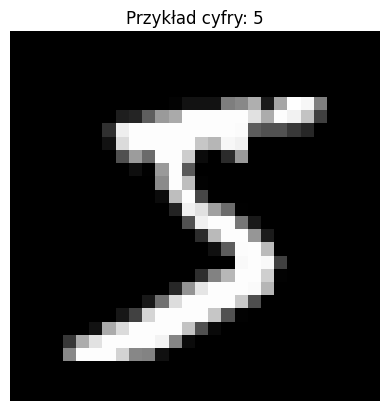

In [58]:
# ładowanie zbioru danych
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

# **Rozwiazanie:**

## **Punkt 1 - wnioski z poprzednich zadań:**


1. **Przygotowanie danych** – Titanic pokazał, że dane muszą być przygotowane
2. **Baseline** - Titanic nauczył, że należy zaczynać od prostego modelu żeby mieć punkt odniesienia i porównanie do naszego.
3. **Overfitting** - tu też trzeba uważać, żeby sieć się nie „nauczyła na pamięć”

## **Punkt 2 - Setup:**

In [59]:
# Przekopiowane z notatnika z lekkimi zmianami

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset, DataLoader, TensorDataset
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

Używane urządzenie: cuda


Podział danych na treningowe (model na nich sie uczy), walidacyjne (model sie dostraja i robi sobie coś a'la egzamin próbny), treningowe (ostateczny test dla modelu) + podgląd danych

55000 5000 10000


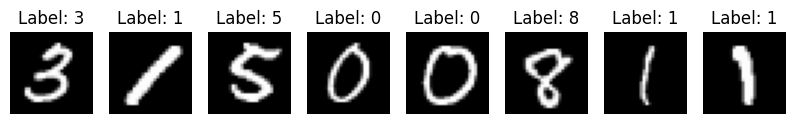

In [60]:
# Podział danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# pobranie danych (zapisze do folderu ./data)
data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

# podział danych na train/val
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 # można zmienić na mniejszy - jeśli nie będzie działać (out of memory error), to TRZEBA zmienić na mniejszy (16,32,64)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(len(train_ds), len(val_ds), len(test_ds))

# Wyświetlenie danych
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

Funkcja treningowa:

In [61]:
EPOCHS = 5
lr = 1e-3
criterion = nn.CrossEntropyLoss()

def run_epoch(model, loader, train: bool):
  # jak epochy wpływają na wynik?
    optimizer = Adam(model.parameters(), lr=lr)
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

## **Punkty 3 - Baseline:**

In [62]:
class SimpleNN(nn.Module): # Prosta sieć neuronowa jako baseline

    def __init__(self, input_size=784, hidden_size=128, num_classes=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_NN = SimpleNN().to(device)

Trening MLP:

In [63]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model_NN, train_loader, train=True)
    va_loss, va_acc = run_epoch(model_NN, val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.3205 acc 0.9094 | val loss 0.1760 acc 0.9458
Ep 02/5 | train loss 0.1377 acc 0.9584 | val loss 0.1280 acc 0.9618
Ep 03/5 | train loss 0.0925 acc 0.9717 | val loss 0.1017 acc 0.9692
Ep 04/5 | train loss 0.0708 acc 0.9775 | val loss 0.0953 acc 0.9696
Ep 05/5 | train loss 0.0562 acc 0.9822 | val loss 0.0870 acc 0.9720
Czas treningu: 55.0s


Monitorowanie Baseline:

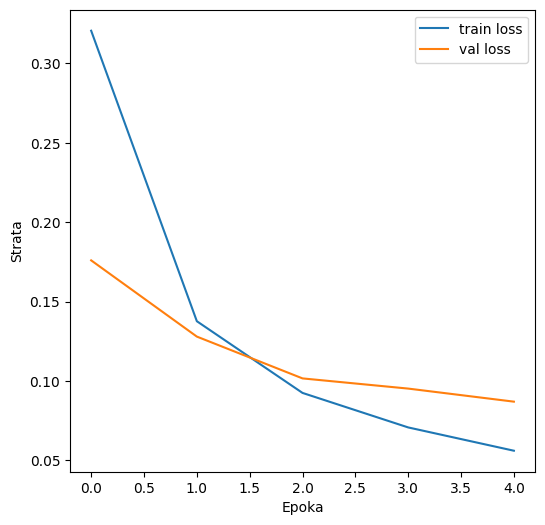

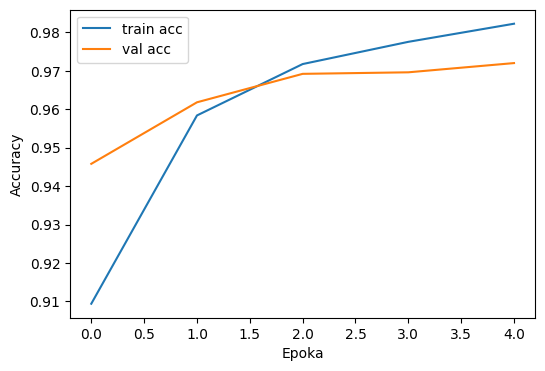

In [64]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Punkt 4 - CNN:**


In [65]:
class BasicCNN(nn.Module):

    def __init__(self, num_classes=10):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicjalizacja
model_cnn = BasicCNN().to(device)

Trening CNN:

In [66]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model_cnn, train_loader, train=True)
    va_loss, va_acc = run_epoch(model_cnn, val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.1698 acc 0.9486 | val loss 0.0756 acc 0.9770
Ep 02/5 | train loss 0.0519 acc 0.9838 | val loss 0.0509 acc 0.9840
Ep 03/5 | train loss 0.0332 acc 0.9894 | val loss 0.0460 acc 0.9852
Ep 04/5 | train loss 0.0243 acc 0.9922 | val loss 0.0380 acc 0.9894
Ep 05/5 | train loss 0.0174 acc 0.9945 | val loss 0.0360 acc 0.9894
Czas treningu: 58.8s


Monitorowanie SimpleCNN:

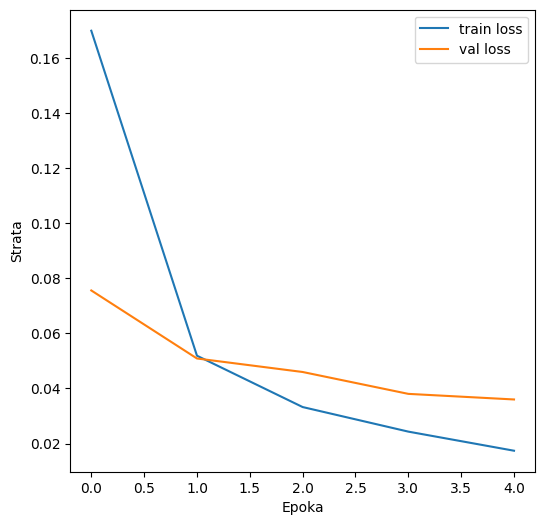

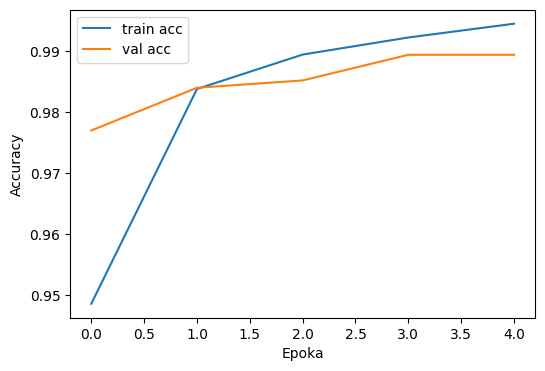

In [67]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Punkt 5 - eksperyment CNN z BatchNorm i dropout:**

In [68]:
class ImprovedCNN(nn.Module):

    def __init__(self, num_classes=10, dropout_rate=0.1):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Inicjalizacja
model_cnn_imp = ImprovedCNN().to(device)

Trening ulepszonego o batchnorm i dropout CNN:

In [69]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model_cnn_imp, train_loader, train=True)
    va_loss, va_acc = run_epoch(model_cnn_imp, val_loader, train=False)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
print(f"Czas treningu: {time.time()-start:.1f}s")

Ep 01/5 | train loss 0.1571 acc 0.9523 | val loss 0.0428 acc 0.9882
Ep 02/5 | train loss 0.0509 acc 0.9845 | val loss 0.0468 acc 0.9842
Ep 03/5 | train loss 0.0369 acc 0.9883 | val loss 0.0541 acc 0.9856
Ep 04/5 | train loss 0.0285 acc 0.9915 | val loss 0.0505 acc 0.9864
Ep 05/5 | train loss 0.0251 acc 0.9926 | val loss 0.0622 acc 0.9848
Czas treningu: 62.2s


Monitorowanie ulepszonego CNN:

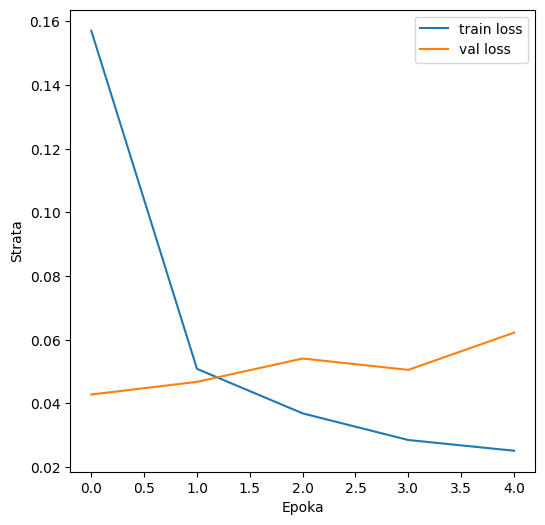

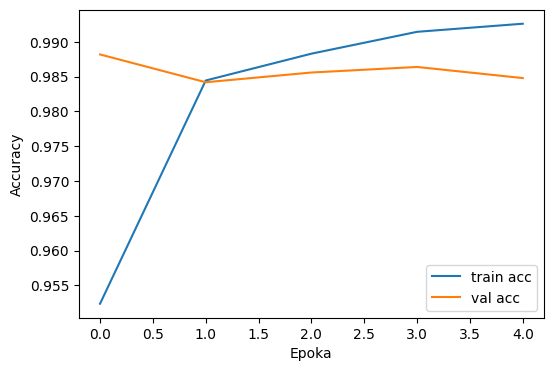

In [70]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## **Wnioski:**

1. Baseline gorzej niż CNN więc to już jakiś sukces 🥺 🙏.  
2. CNN – ~99% dokładności i w sumie nic dziwnego bo to naturalny wybór dla obrazów.  
3. CNN z BatchNorm i dropout dał bardzo zbliżony wynik zapewne przez to że w praktyce – prosty CNN wystarcza na MNIST, ale na bardziej rozbudowanych datasetach może architektura i regularizacja mają dużo większe znaczenie.